<a href="https://colab.research.google.com/github/gas300/Progetto-ICON-Gabriele-Marrano/blob/main/Progetto_Icon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Titolo**

*descrizione progetto*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##**Creazione e preelaborazione del dataframe**

###**Installazione librerie**

In [ ]:
!pip install --upgrade matplotlib
!pip install imbalanced-learn
!pip install tqdm




import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import sklearn as skl
from tqdm import tqdm
import warnings


from sklearn.svm import SVC
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, GridSearchCV

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, confusion_matrix, recall_score, classification_report, precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from collections import Counter


Il dataset di approvazione del prestito è una raccolta di documenti finanziari e informazioni associate utilizzate per determinare l'idoneità di individui o organizzazioni a ottenere prestiti da un istituto di credito. Include varie features come il punteggio civico, il reddito, lo stato occupazionale, la durata del prestito, l'importo del prestito, il valore patrimoniale e lo stato del prestito.

Spiegazione delle features:
- `no_of_dependents`: Numero di persone a carico del richiedente
- `education`: Livello di struzione del richiedente
- `self_employed`: Condizione occupazionale del richiedente
- `income_annum`: Reddito annuale del richiedente
- `loan_amount	`: Ammontare del prestito
- `loan_term`: Durata del prestito in anni
- `cibil_score`: Punteggio rappresentante la solvibilità creditizia dei richiedenti di prestiti o mutui. E' calcolato dall'agenzia di informazione di credito Credit Information Bureau India Limited (CIBIL)
- `residential_assets_value`: Valore dei beni residenziali
- `commercial_assets_value`: Valore dei beni commerciali
- `luxury_assets_value`: Valore dei beni di lusso
- `bank_asset_value`: Valore dei beni depositati in banca
- `loan_status`: Stato di approvazione del prestito

Il caso di studio parte quindi con la lettura del dataset e la creazione del dataframe, segue con una fase di preelaborazione del dataframe per rendere, inizialmente una migliore compresione della struttura di questo, e successivamente ottimizzarlo per le operazioni successive.

In [ ]:
# Lettura del dataset e creazione del dataframe
df = pd.read_csv('/content/drive/MyDrive/loan_approval_dataset.csv')

# Eliminazione della prima colonna in quanto rappresentate soltanto il numero della riga
df = df.drop(df.columns[0], axis=1)

# Simbolo della valuta da aggiungere
simbolo_valuta = '₹'

# Formatta la colonna 'prezzo' con il simbolo della valuta indiana utilizzando apply() e una f-string
df['income_annum'] = df['income_annum'].apply(lambda x: f'{simbolo_valuta}{x:,.2f}')
df['loan_amount'] = df['loan_amount'].apply(lambda x: f'{simbolo_valuta}{x:,.2f}')
df['residential_assets_value'] = df['residential_assets_value'].apply(lambda x: f'{simbolo_valuta}{x:,.2f}')
df['commercial_assets_value'] = df['commercial_assets_value'].apply(lambda x: f'{simbolo_valuta}{x:,.2f}')
df['luxury_assets_value'] = df['luxury_assets_value'].apply(lambda x: f'{simbolo_valuta}{x:,.2f}')
df['bank_asset_value'] = df['bank_asset_value'].apply(lambda x: f'{simbolo_valuta}{x:,.2f}')

# Prime cinque righe del dataframe
df.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,Graduate,No,"₹9,600,000.00","₹29,900,000.00",12,778,"₹2,400,000.00","₹17,600,000.00","₹22,700,000.00","₹8,000,000.00",Approved
1,0,Not Graduate,Yes,"₹4,100,000.00","₹12,200,000.00",8,417,"₹2,700,000.00","₹2,200,000.00","₹8,800,000.00","₹3,300,000.00",Rejected
2,3,Graduate,No,"₹9,100,000.00","₹29,700,000.00",20,506,"₹7,100,000.00","₹4,500,000.00","₹33,300,000.00","₹12,800,000.00",Rejected
3,3,Graduate,No,"₹8,200,000.00","₹30,700,000.00",8,467,"₹18,200,000.00","₹3,300,000.00","₹23,300,000.00","₹7,900,000.00",Rejected
4,5,Not Graduate,Yes,"₹9,800,000.00","₹24,200,000.00",20,382,"₹12,400,000.00","₹8,200,000.00","₹29,400,000.00","₹5,000,000.00",Rejected


Seppur decisamente facilmente leggibile e perfettamente formattata, la tabella posta qui sopra rende difficoltose tutte le operazione matematiche che seguiranno, perciò si è deciso di mostrare la tabella per dare la possibilità, al lettore/utilizzatore di questo applicativo, di una **più semplice compresione** dei valori tabellari e della struttura del dataframe.
Per il proseguo del caso di studio invece si utilizzerà la tabella ricavata nel seguente passaggio, che mappa i valori stringa rappresentati situazione binarie in appunto valori numeri di 0 e 1 per rispettivamente l'assenza e la presenza del valore della feature in questione

In [ ]:
# Sostituzione valori binari in formato stringa in equivalente numerico
df['education'] = df['education'].replace('Graduate', 1)
df['education'] = df['education'].replace('Not Graduate', 0)
df['self_employed'] = df['self_employed'].replace('Yes', 1)
df['self_employed'] = df['self_employed'].replace('No', 0)
df['loan_status'] = df['loan_status'].replace('Approved', 1)
df['loan_status'] = df['loan_status'].replace('Rejected', 0)


# Eliminazione del simbolo 'rupia indiana' e riconversione in float
df['income_annum'] = df['income_annum'].apply(lambda x: float(x.replace(simbolo_valuta, '').replace(',', '')))
df['loan_amount'] = df['loan_amount'].apply(lambda x: float(x.replace(simbolo_valuta, '').replace(',', '')))
df['residential_assets_value'] = df['residential_assets_value'].apply(lambda x: float(x.replace(simbolo_valuta, '').replace(',', '')))
df['commercial_assets_value'] = df['commercial_assets_value'].apply(lambda x: float(x.replace(simbolo_valuta, '').replace(',', '')))
df['luxury_assets_value'] = df['luxury_assets_value'].apply(lambda x: float(x.replace(simbolo_valuta, '').replace(',', '')))
df['bank_asset_value'] = df['bank_asset_value'].apply(lambda x: float(x.replace(simbolo_valuta, '').replace(',', '')))


# Prime cinque righe del dataframe
df.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,1,0,9600000.0,29900000.0,12,778,2400000.0,17600000.0,22700000.0,8000000.0,1
1,0,0,1,4100000.0,12200000.0,8,417,2700000.0,2200000.0,8800000.0,3300000.0,0
2,3,1,0,9100000.0,29700000.0,20,506,7100000.0,4500000.0,33300000.0,12800000.0,0
3,3,1,0,8200000.0,30700000.0,8,467,18200000.0,3300000.0,23300000.0,7900000.0,0
4,5,0,1,9800000.0,24200000.0,20,382,12400000.0,8200000.0,29400000.0,5000000.0,0


In [ ]:
# controllo dei valori mancanti in ogni colonna del dataframe
df.isnull().sum()

no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

### **Valutazione correlazioni**

Una volta creato il dataframe si prosegue con un'analisi e una valutazione delle correlazioni tra le features per estrapolare attraverso il processo di inferenza deduttiva quante più informazioni possibili.

<Axes: >

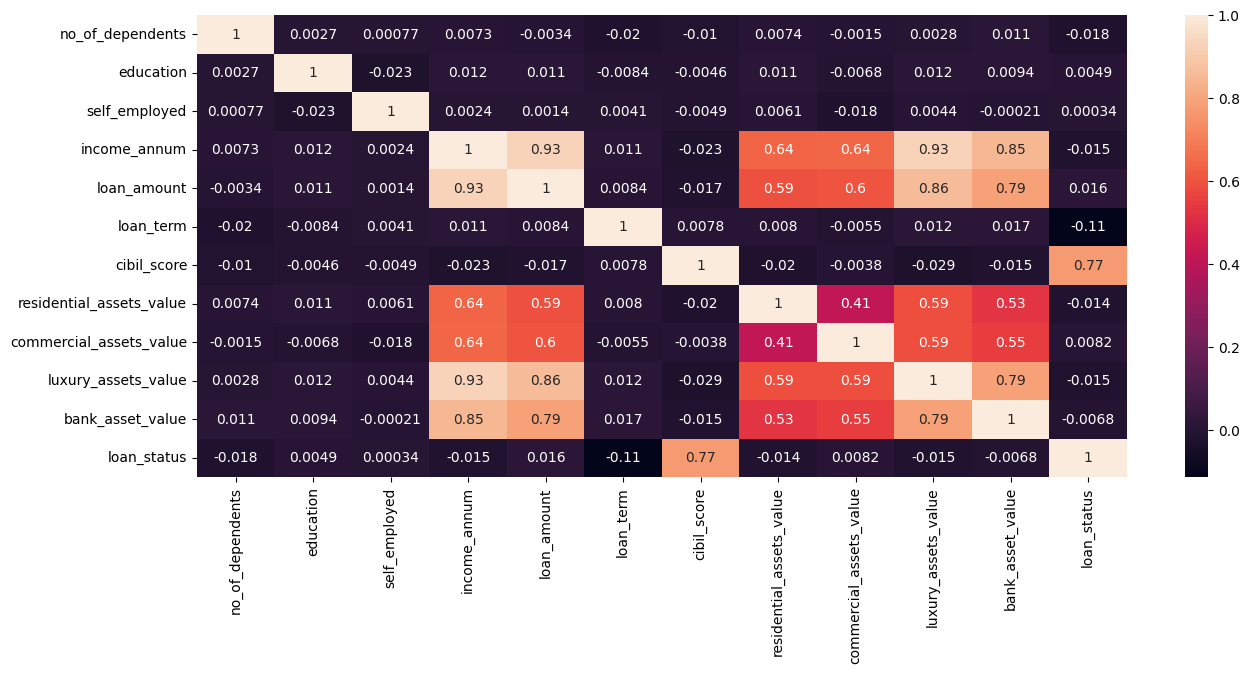

In [ ]:
plt.figure(figsize = (15,6))
sns.heatmap(df.corr(), annot=True)

Prime osservazioni:


*   Il reddito annuale presenta una forte correlazione diretta con l'ammontare del prestito richiesto e i valori del bene di lusso. Inoltre non trascurabile la buona correlazione diretta anche con il valore di asset commerciali e residenziali, nonchè il valore dei beni bancari
*   La richiesta della quantià di debito rispecchia molto le correlazioni presenti nel punto precedente
*   Il valore dei beni residenziali, di lusso e commerciali presentano una non trascurabile correlazione tra essi
*   L' **approvazione del prestito** presenta un'importante correlazione con il punteggio calcolato dal CIBIL



<Axes: xlabel='loan_status', ylabel='count'>

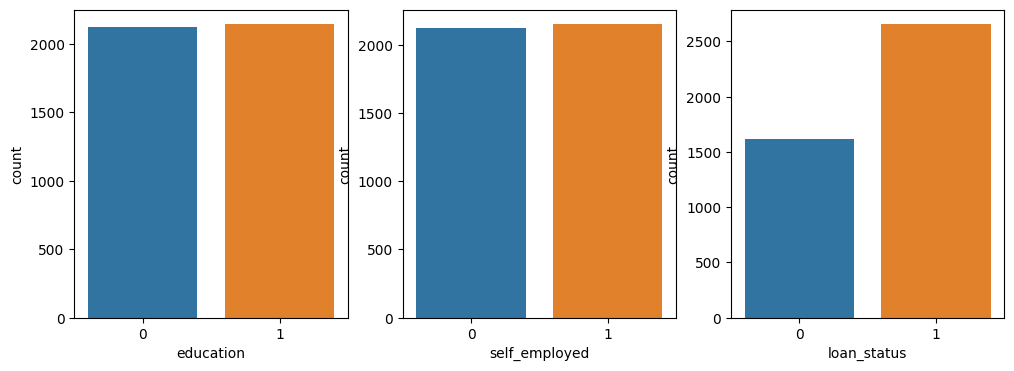

In [ ]:
plt.figure(figsize = (12,4))

plt.subplot(1,3,1)
sns.countplot(x = 'education', data = df)

plt.subplot(1,3,2)
sns.countplot(x = 'self_employed', data = df)

plt.subplot(1,3,3)
sns.countplot(x = 'loan_status', data = df)


E' possibile notare come il dataframe in questione, seppur non perfettamente bilanciato sulla variabile target, non presenti gravi segni di sbilanciamento.
In seguito verrà valutato l'utilizzo dell'undersampling e dell'oversampling per migliorare le performance dei modelli di ML.

<Axes: xlabel='bank_asset_value'>

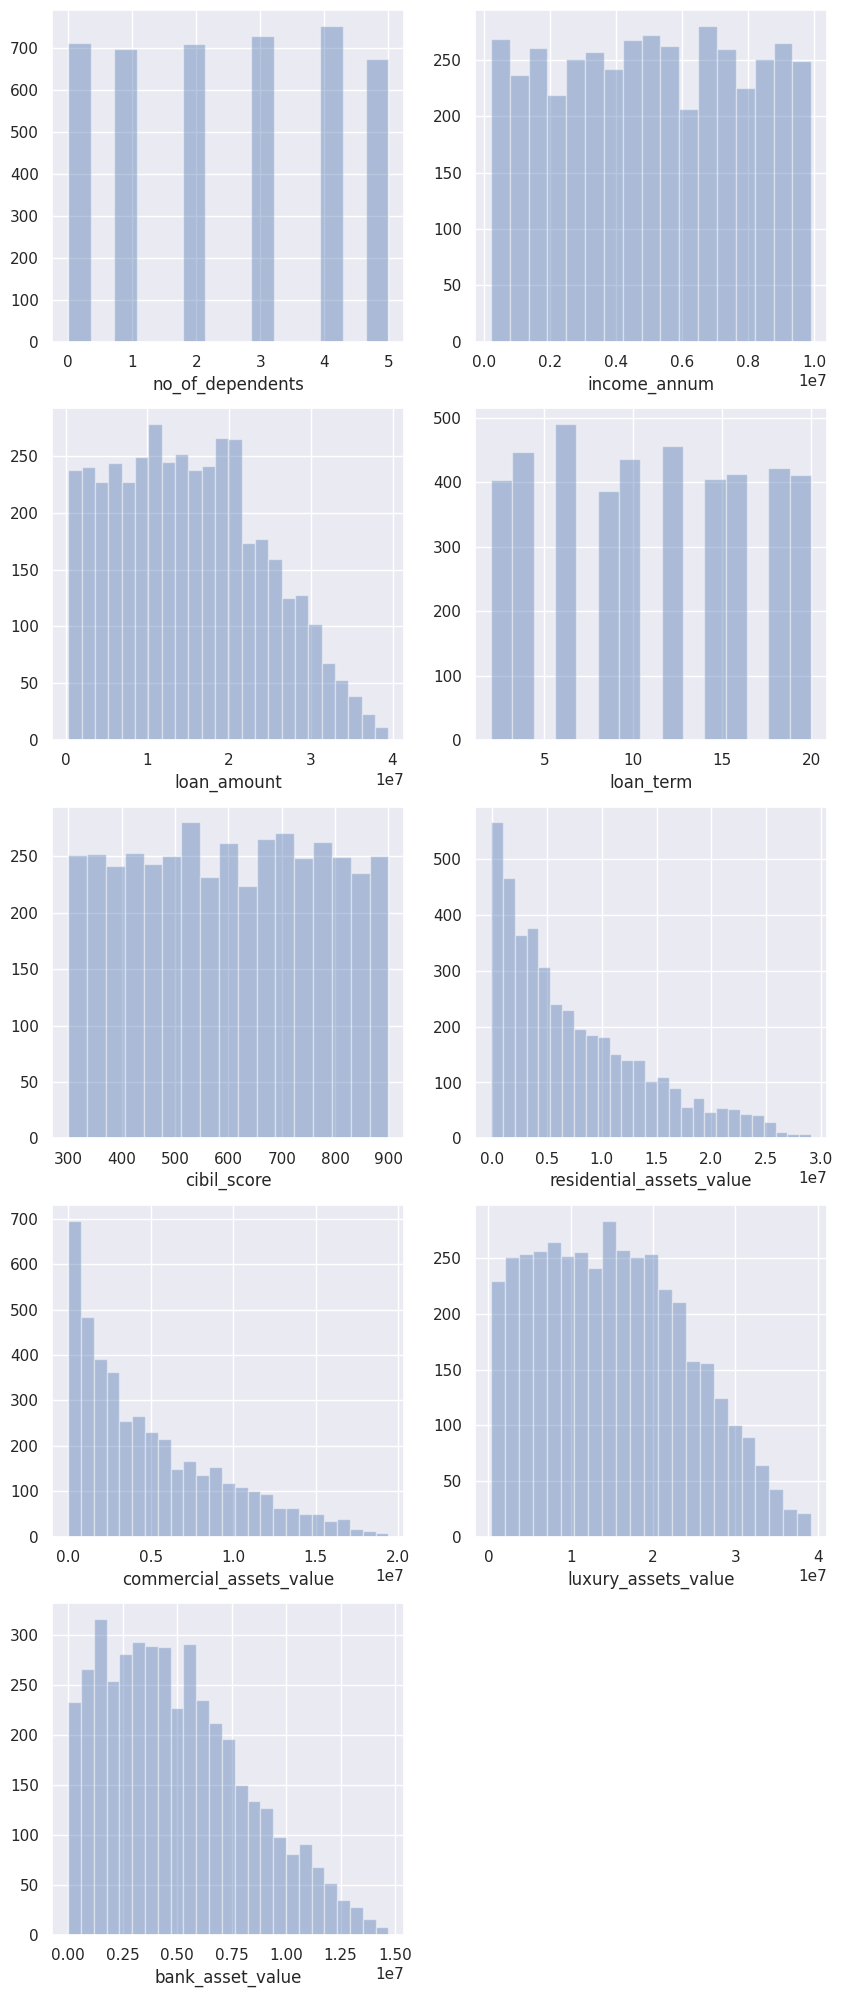

In [ ]:

warnings.filterwarnings("ignore")
plt.figure(figsize = (10,25))

sns.set(color_codes = True)

plt.subplot(5,2,1)
sns.distplot(df.no_of_dependents, kde=False)

plt.subplot(5,2,2)
sns.distplot(df.income_annum, kde=False)

plt.subplot(5,2,3)
sns.distplot(df.loan_amount, kde=False)

plt.subplot(5,2,4)
sns.distplot(df.loan_term, kde=False)

plt.subplot(5,2,5)
sns.distplot(df.cibil_score, kde=False)

plt.subplot(5,2,6)
sns.distplot(df.residential_assets_value, kde=False)

plt.subplot(5,2,7)
sns.distplot(df.commercial_assets_value, kde=False)

plt.subplot(5,2,8)
sns.distplot(df.luxury_assets_value, kde=False)

plt.subplot(5,2,9)
sns.distplot(df.bank_asset_value, kde=False)

Altre osservazioni che possono essere fatte sono leseguenti:


*   Il dataframe presenta una varietà di soggetti ottimamente bilanciata per quanto riguarda il reddito annuale del richiedente.
*   Nonostante il punto precedente è possibile notare una decisa differenza nella gestione del denaro, in particolare:

  *   La richiesta di prestito presenta valori molto simili a quella del valore dei beni di lusso, questo potrebbe significare che la tendenza dei soggetti nel dataframe sia quella di comprare beni di lusso attraverso la richiesta di un mutuo
  *   E' presente un numero di soggetti decisamente elevato che non possiede o possiede in scarse quantità beni commerciali o residenziali che appunto sono una forma importante di reddito generato da investimenti

*   Una fetta molto consistente dei richiedenti di un prestito detiene un deposito di beni bancari (denaro liquido, partecipazioni in fondi comuni di risparmio/investimento, azioni, titoli di stato ecc..) piuttosto ridotto. Ciò può significare quanto segue:

  *   Un ampia circolazione di contante
  *   Gran parte del reddito viene utilizzato per spese ordinarie











### **Separazione features e target**

Si prosegue quindi con la separazione del dataframe in variabili indipendenti (features/predittori), contenuta nella lista X, e della variabile dipendente (target/etichetta), contenuta in Y.

In [ ]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

## **Apprendimento supervisionato**

L'apprendimento supervisionato è uno dei principali approcci nell'ambito del machine learning, che consiste nell'addestrare un modello utilizzando un insieme di dati di addestramento etichettato.
Alcune considerazioni:


1.   Il dataframe risulta essere **sbilanciato**. In particolare lo stato dei prestiti approvati è di circa il 62% maggiore rispetto a quelli non approvati. ***Seppure non è uno sbilanciamento estremo*** si è deciso di verificare se l'applicazione di tecniche di **oversampling** e **undersampling** potesse portare migliori performance.
2.   Per ottimizzare le performance si farà utilizzo di una **Grid Search**. La Grid Search è una tecnica utilizzata per ottimizzare i parametri di un modello di machine learning. L'idea principale è di esplorare tutte le combinazioni possibili di valori dei parametri specificati in una griglia predefinita e selezionare la combinazione che offre le migliori prestazioni del modello.
3.  Al fine di ottenere una stima più affidabile delle prestazioni del modello rispetto a una singola divisione in set di addestramento e test si è deciso di usare la tecnica di **k-fold cross-validation**. L'obiettivo della k-fold cross-validation è quello di suddividere il dataset in k subset (folds) di dimensioni approssimativamente uguali. Il modello viene addestrato e valutato k volte, utilizzando k-1 folds come set di addestramento e l'ultimo fold come set di test.
4.  Si è deciso di **ottimizzare la precision** in quanto predire un errore di debito approvato quando in realtà non è così, non è più o meno aggravante del caso opposto.

Questo capitolo quindi si evolverà come segue:


*   Per ogni modello si eseguiranno i 3 seguenti casi:
    1.  Creazione modello --> applicazione della grid search per ottimizzazione parametri --> K-fold cross validation per addestramento e test --> Calcolo performance
    2.  Creazione modello --> applicazione undersampling al df --> applicazione della grid search per ottimizzazione parametri --> K-fold cross validation per addestramento e test --> Calcolo performance
    3.  Creazione modello --> applicazione oversampling al df --> applicazione della grid search per ottimizzazione parametri --> K-fold cross validation per addestramento e test --> Calcolo performance

    I modelli utilizzati sono: Knn, SVM, Random Forest e

*   Discussione delle performance e conclusioni



In [ ]:
# Creare un DataFrame vuoto
df_performance = pd.DataFrame()

###**KNN**

####**KNN con dataframe originale**

In [ ]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Creare il classificatore k-NN
knn_classifier = KNeighborsClassifier()

# Definire i parametri da testare con GridSearchCV
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23],
    'weights': ['uniform', 'distance'],
}

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creare l'oggetto StratifiedKFold per la k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Creare l'oggetto GridSearchCV
grid_search = GridSearchCV(knn_classifier, param_grid, scoring=scoring, refit='precision', cv=stratified_kfold)

# Effettuare la ricerca dei parametri ottimali utilizzando GridSearchCV
grid_search.fit(X, y)

# Visualizzare i parametri ottimali
print("Parametri ottimali:", grid_search.best_params_)


# Effettuare la k-fold cross-validation con sampling
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Ottenere il miglior modello con i parametri ottimali
    best_knn_classifier = grid_search.best_estimator_

    # Effettuare le previsioni sul set di test
    y_pred = best_knn_classifier.predict(X_test)

    # Calcolo metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'KNN df originale',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

df_performance = df_performance.append(model_performance, ignore_index=True)


Parametri ottimali: {'n_neighbors': 5, 'weights': 'uniform'}
Average Recall: 0.8475159597105973
Average Precision: 0.7325308433555728
Average Accuracy: 0.7123473078910623
Average F1-score: 0.785692595298968


####**KNN con undersampling del dataframe**

In [ ]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Creare il classificatore k-NN
knn_classifier = KNeighborsClassifier()

# Definire i parametri da testare con GridSearchCV
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23],
    'weights': ['uniform', 'distance'],
}

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creare l'oggetto StratifiedKFold per la k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Applica l'undersampling
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Creare l'oggetto GridSearchCV
grid_search = GridSearchCV(knn_classifier, param_grid, scoring=scoring, refit='precision', cv=stratified_kfold)

# Effettuare la ricerca dei parametri ottimali utilizzando GridSearchCV
grid_search.fit(X_resampled, y_resampled)

# Visualizzare i parametri ottimali
print("Parametri ottimali:", grid_search.best_params_)


# Effettuare la k-fold cross-validation con undersampling
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Ottenere il miglior modello con i parametri ottimali
    best_knn_classifier = grid_search.best_estimator_

    # Effettuare le previsioni sul set di test
    y_pred = best_knn_classifier.predict(X_test)

    # Calcolo metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'KNN df undersampled',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

df_performance = df_performance.append(model_performance, ignore_index=True)


Parametri ottimali: {'n_neighbors': 3, 'weights': 'uniform'}
Average Recall: 0.7767962579556781
Average Precision: 0.7489302345570664
Average Accuracy: 0.7578928138761225
Average F1-score: 0.7622142295875178


####**KNN con oversampling del dataframe**

In [ ]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Creare il classificatore k-NN
knn_classifier = KNeighborsClassifier()

# Definire i parametri da testare con GridSearchCV
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23],
    'weights': ['uniform', 'distance'],
}

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creare l'oggetto StratifiedKFold per la k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Applica l'oversampling
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Creare l'oggetto GridSearchCV
grid_search = GridSearchCV(knn_classifier, param_grid, scoring=scoring, refit='precision', cv=stratified_kfold)

# Effettuare la ricerca dei parametri ottimali utilizzando GridSearchCV
grid_search.fit(X_resampled, y_resampled)

# Visualizzare i parametri ottimali
print("Parametri ottimali:", grid_search.best_params_)


# Effettuare la k-fold cross-validation con oversampling
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Ottenere il miglior modello con i parametri ottimali
    best_knn_classifier = grid_search.best_estimator_

    # Effettuare le previsioni sul set di test
    y_pred = best_knn_classifier.predict(X_test)

    # Calcolo metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'KNN df oversampled',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

df_performance = df_performance.append(model_performance, ignore_index=True)

Parametri ottimali: {'n_neighbors': 9, 'weights': 'distance'}
Average Recall: 1.0
Average Precision: 1.0
Average Accuracy: 1.0
Average F1-score: 1.0


###**SVM**

####**SVM con dataframe originale**

In [ ]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Creare il classificatore SVM
svm_classifier = SVC()

# Definire i parametri da testare con GridSearchCV
param_grid = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 5, 10],
    'gamma': ['scale', 'auto']
}

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creare l'oggetto StratifiedKFold per la k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Creare l'oggetto GridSearchCV
grid_search = GridSearchCV(svm_classifier, param_grid, scoring=scoring, refit='precision', cv=stratified_kfold)

# Effettuare la ricerca dei parametri ottimali utilizzando GridSearchCV
grid_search.fit(X, y)

# Visualizzare i parametri ottimali
print("Parametri ottimali:", grid_search.best_params_)

# Effettuare la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Ottenere il miglior modello con i parametri ottimali
    best_svm_classifier = grid_search.best_estimator_

    # Effettuare le previsioni sul set di test
    y_pred = best_svm_classifier.predict(X_test)

    # Calcolo metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'SVM df originale',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

df_performance = df_performance.append(model_performance, ignore_index=True)


Parametri ottimali: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Average Recall: 1.0
Average Precision: 0.622159734362459
Average Accuracy: 0.622159734362459
Average F1-score: 0.7670752808866291


####**SVM con undersampling del dataframe**

In [ ]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Creare il classificatore SVM
svm_classifier = SVC()

# Definire i parametri da testare con GridSearchCV
param_grid = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 5, 10],
    'gamma': ['scale', 'auto']
}

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creare l'oggetto StratifiedKFold per la k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Applica l'undersampling
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Creare l'oggetto GridSearchCV
grid_search = GridSearchCV(svm_classifier, param_grid, scoring=scoring, refit='precision', cv=stratified_kfold)

# Effettuare la ricerca dei parametri ottimali utilizzando GridSearchCV
grid_search.fit(X_resampled, y_resampled)

# Visualizzare i parametri ottimali
print("Parametri ottimali:", grid_search.best_params_)

# Effettuare la k-fold cross-validation con undersampling
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Ottenere il miglior modello con i parametri ottimali
    best_svm_classifier = grid_search.best_estimator_

    # Effettuare le previsioni sul set di test
    y_pred = best_svm_classifier.predict(X_test)

    # Calcolo metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'SVM df undersampled',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

df_performance = df_performance.append(model_performance, ignore_index=True)


Parametri ottimali: {'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}
Average Recall: 0.6962081128747796
Average Precision: 0.5465006499547435
Average Accuracy: 0.5592061996423283
Average F1-score: 0.6119510452586107


####**SVM con oversampling del dataframe**

In [ ]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Creare il classificatore SVM
svm_classifier = SVC()

# Definire i parametri da testare con GridSearchCV
param_grid = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 5, 10],
    'gamma': ['scale', 'auto']
}

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creare l'oggetto StratifiedKFold per la k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Applica l'oversampling
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Creare l'oggetto GridSearchCV
grid_search = GridSearchCV(svm_classifier, param_grid, scoring=scoring, refit='precision', cv=stratified_kfold)

# Effettuare la ricerca dei parametri ottimali utilizzando GridSearchCV
grid_search.fit(X_resampled, y_resampled)

# Visualizzare i parametri ottimali
print("Parametri ottimali:", grid_search.best_params_)


# Effettuare la k-fold cross-validation con oversampling
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Ottenere il miglior modello con i parametri ottimali
    best_svm_classifier = grid_search.best_estimator_

    # Effettuare le previsioni sul set di test
    y_pred = best_svm_classifier.predict(X_test)

    # Calcolo metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'SVM df oversampled',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

df_performance = df_performance.append(model_performance, ignore_index=True)


Parametri ottimali: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Average Recall: 1.0
Average Precision: 1.0
Average Accuracy: 1.0
Average F1-score: 1.0


###**Random Forest**

####**Random forest con dataframe originale**

In [ ]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Creare il classificatore Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

# Definire i parametri da testare con GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 1, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creare l'oggetto StratifiedKFold per la k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Creare l'oggetto GridSearchCV
grid_search = GridSearchCV(rf_classifier, param_grid, scoring=scoring, refit='precision', cv=stratified_kfold)

# Effettuare la ricerca dei parametri ottimali utilizzando GridSearchCV
grid_search.fit(X, y)

# Visualizzare i parametri ottimali
print("Parametri ottimali:", grid_search.best_params_)

# Effettuare la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Ottenere il miglior modello con i parametri ottimali
    best_rf_classifier = grid_search.best_estimator_

    # Effettuare le previsioni sul set di test
    y_pred = best_rf_classifier.predict(X_test)

    # Calcolo metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'RF df originale',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

df_performance = df_performance.append(model_performance, ignore_index=True)


Parametri ottimali: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Average Recall: 0.9597134345297205
Average Precision: 0.9945560621542139
Average Accuracy: 0.9716523182812724
Average F1-score: 0.976788449747706


####**Random forest con undersampling del dataframe**

In [ ]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Creare il classificatore Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

# Definire i parametri da testare con GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 1, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creare l'oggetto StratifiedKFold per la k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Applica l'undersampling
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Creare l'oggetto GridSearchCV
grid_search = GridSearchCV(rf_classifier, param_grid, scoring=scoring, refit='precision', cv=stratified_kfold)

# Effettuare la ricerca dei parametri ottimali utilizzando GridSearchCV
grid_search.fit(X_resampled, y_resampled)

# Visualizzare i parametri ottimali
print("Parametri ottimali:", grid_search.best_params_)

# Effettuare la k-fold cross-validation con undersampling
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Ottenere il miglior modello con i parametri ottimali
    best_rf_classifier = grid_search.best_estimator_

    # Effettuare le previsioni sul set di test
    y_pred = best_rf_classifier.predict(X_test)

    # Calcolo metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'RF df undersampled',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

df_performance = df_performance.append(model_performance, ignore_index=True)


Parametri ottimali: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Average Recall: 0.9522812667740205
Average Precision: 0.9929741296455905
Average Accuracy: 0.9727208045689671
Average F1-score: 0.972112109081184


####**Random forest con oversampling del dataframe**

In [ ]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Creare il classificatore Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

# Definire i parametri da testare con GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 1, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creare l'oggetto StratifiedKFold per la k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Applica l'oversampling
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Creare l'oggetto GridSearchCV
grid_search = GridSearchCV(rf_classifier, param_grid, scoring=scoring, refit='precision', cv=stratified_kfold)

# Effettuare la ricerca dei parametri ottimali utilizzando GridSearchCV
grid_search.fit(X_resampled, y_resampled)

# Visualizzare i parametri ottimali
print("Parametri ottimali:", grid_search.best_params_)

# Effettuare la k-fold cross-validation con undersampling
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]


    # Ottenere il miglior modello con i parametri ottimali
    best_rf_classifier = grid_search.best_estimator_

    # Effettuare le previsioni sul set di test
    y_pred = best_rf_classifier.predict(X_test)

    # Calcolo metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'RF df oversampled',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

df_performance = df_performance.append(model_performance, ignore_index=True)


Parametri ottimali: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Average Recall: 0.9461611576110085
Average Precision: 0.9937139261958652
Average Accuracy: 0.9700667629525791
Average F1-score: 0.9692945026765905


###**MLP**

####**MLP con dataframe originale**

In [ ]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Creare il classificatore Multi-Layer Perceptron (MLP)
mlp_classifier = MLPClassifier(random_state=42)

# Definire i parametri da testare con GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'alpha': [0.0001, 0.001, 0.01]
}

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creare l'oggetto StratifiedKFold per la k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Creare l'oggetto GridSearchCV
grid_search = GridSearchCV(mlp_classifier, param_grid, scoring=scoring, refit='precision', cv=stratified_kfold)

# Effettuare la ricerca dei parametri ottimali utilizzando GridSearchCV
grid_search.fit(X, y)

# Visualizzare i parametri ottimali
print("Parametri ottimali:", grid_search.best_params_)

# Effettuare la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Ottenere il miglior modello con i parametri ottimali
    best_mlp_classifier = grid_search.best_estimator_

    # Effettuare le previsioni sul set di test
    y_pred = best_mlp_classifier.predict(X_test)

    # Calcolo metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'MLP df originale',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

df_performance = df_performance.append(model_performance, ignore_index=True)


Parametri ottimali: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,)}
Average Recall: 0.4216910200028373
Average Precision: 0.682286270263561
Average Accuracy: 0.5179228375718794
Average F1-score: 0.5208299485073952


####**MLP con undersampling del dataframe**

In [ ]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Creare il classificatore Multi-Layer Perceptron (MLP)
mlp_classifier = MLPClassifier(random_state=42)

# Definire i parametri da testare con GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'alpha': [0.0001, 0.001, 0.01]
}

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creare l'oggetto StratifiedKFold per la k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Applica l'undersampling
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Creare l'oggetto GridSearchCV
grid_search = GridSearchCV(mlp_classifier, param_grid, scoring=scoring, refit='precision', cv=stratified_kfold)

# Effettuare la ricerca dei parametri ottimali utilizzando GridSearchCV
grid_search.fit(X_resampled, y_resampled)

# Visualizzare i parametri ottimali
print("Parametri ottimali:", grid_search.best_params_)

# Effettuare la k-fold cross-validation con undersampling
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Ottenere il miglior modello con i parametri ottimali
    best_mlp_classifier = grid_search.best_estimator_

    # Effettuare le previsioni sul set di test
    y_pred = best_mlp_classifier.predict(X_test)

    # Calcolo metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'MLP df undersampled',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

df_performance = df_performance.append(model_performance, ignore_index=True)


Parametri ottimali: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50,)}
Average Recall: 0.013645425964266544
Average Precision: 0.58
Average Accuracy: 0.502483510566698
Average F1-score: 0.026630780327518498


####**MLP con oversampling del dataframe**

In [ ]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Creare il classificatore Multi-Layer Perceptron (MLP)
mlp_classifier = MLPClassifier(random_state=42)

# Definire i parametri da testare con GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'alpha': [0.0001, 0.001, 0.01]
}

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creare l'oggetto StratifiedKFold per la k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Applica l'oversampling
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Creare l'oggetto GridSearchCV
grid_search = GridSearchCV(mlp_classifier, param_grid, scoring=scoring, refit='precision', cv=stratified_kfold)

# Effettuare la ricerca dei parametri ottimali utilizzando GridSearchCV
grid_search.fit(X_resampled, y_resampled)

# Visualizzare i parametri ottimali
print("Parametri ottimali:", grid_search.best_params_)

# Effettuare la k-fold cross-validation con undersampling
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Ottenere il miglior modello con i parametri ottimali
    best_mlp_classifier = grid_search.best_estimator_

    # Effettuare le previsioni sul set di test
    y_pred = best_mlp_classifier.predict(X_test)

    # Calcolo metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'MLP df oversampled',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

df_performance = df_performance.append(model_performance, ignore_index=True)


Parametri ottimali: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50,)}
Average Recall: 0.958218186976876
Average Precision: 0.5060670749664364
Average Accuracy: 0.5114842190221316
Average F1-score: 0.6623239398793805


###**Discussione risultati**

In [ ]:
!pip install tabulate
from tabulate import tabulate

# Mostrare la tabella delle performance utilizzando tabulate
print(tabulate(df_performance, headers='keys', tablefmt='psql'))


+----+---------------------+-----------+-------------+------------+------------+
|    | Modello             |    Recall |   Precision |   Accuracy |   F1-score |
|----+---------------------+-----------+-------------+------------+------------|
|  0 | KNN df originale    | 0.847516  |    0.732531 |   0.712347 |  0.785693  |
|  1 | KNN df undersampled | 0.776796  |    0.74893  |   0.757893 |  0.762214  |
|  2 | KNN df oversampled  | 1         |    1        |   1        |  1         |
|  3 | SVM df originale    | 1         |    0.62216  |   0.62216  |  0.767075  |
|  4 | SVM df undersampled | 0.696208  |    0.546501 |   0.559206 |  0.611951  |
|  5 | SVM df oversampled  | 1         |    1        |   1        |  1         |
|  6 | RF df originale     | 0.959713  |    0.994556 |   0.971652 |  0.976788  |
|  7 | RF df undersampled  | 0.952281  |    0.992974 |   0.972721 |  0.972112  |
|  8 | RF df oversampled   | 0.946161  |    0.993714 |   0.970067 |  0.969295  |
|  9 | MLP df originale    |